## 导入包

In [32]:
import os
import random
import numpy as np
import cv2
import base64

from PIL import Image, ImageDraw, ImageFont
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, HTML

## 制作训练数据集

In [33]:
os.makedirs('training_dataset', exist_ok=True)

# Define the number of videos to generate for the dataset
num_videos = 300 #30000

# Define the number of frames per video (1 Second Video)
frames_per_video = 10

# Define the size of each image in the dataset
img_size = (64, 64)

# Define the size of the shapes (Circle)
shape_size = 10

# Define text prompts and corresponding movements for circles
prompts_and_movements = [
    ("circle moving down", "circle", "down"),  # Move circle downward
    ("circle moving left", "circle", "left"),  # Move circle leftward
    ("circle moving right", "circle", "right"),  # Move circle rightward
    ("circle moving diagonally up-right", "circle", "diagonal_up_right"),  # Move circle diagonally up-right
    ("circle moving diagonally down-left", "circle", "diagonal_down_left"),  # Move circle diagonally down-left
    ("circle moving diagonally up-left", "circle", "diagonal_up_left"),  # Move circle diagonally up-left
    ("circle moving diagonally down-right", "circle", "diagonal_down_right"),  # Move circle diagonally down-right
    ("circle rotating clockwise", "circle", "rotate_clockwise"),  # Rotate circle clockwise
    ("circle rotating counter-clockwise", "circle", "rotate_counter_clockwise"),  # Rotate circle counter-clockwise
    ("circle bouncing vertically", "circle", "bounce_vertical"),  # Bounce circle vertically
    ("circle bouncing horizontally", "circle", "bounce_horizontal"),  # Bounce circle horizontally
    ("circle zigzagging vertically", "circle", "zigzag_vertical"),  # Zigzag circle vertically
    ("circle zigzagging horizontally", "circle", "zigzag_horizontal"),  # Zigzag circle horizontally
    ("circle moving up-left", "circle", "up_left"),  # Move circle up-left
    ("circle moving down-right", "circle", "down_right"),  # Move circle down-right
    ("circle moving down-left", "circle", "down_left")  # Move circle down-left
]

# Define a function to create an image with a moving shape
def create_image_with_moving_shape(size, frame_num, shape, direction):
    # Create a new RGB image with the specified size and white background
    img = Image.new('RGB', size, color=(255, 255, 255))
    draw = ImageDraw.Draw(img)

    # Calculate the initial position of the shape (center of the image)
    center_x, center_y = size[0] // 2, size[1] // 2

    # Determine the shape position based on the movement direction
    if direction == "down":
        position = (center_x, (center_y + frame_num * 5) % size[1])
    elif direction == "left":
        position = ((center_x - frame_num * 5) % size[0], center_y)
    elif direction == "right":
        position = ((center_x + frame_num * 5) % size[0], center_y)
    elif direction == "diagonal_up_right":
        position = ((center_x + frame_num * 5) % size[0], (center_y - frame_num * 5) % size[1])
    elif direction == "diagonal_down_left":
        position = ((center_x - frame_num * 5) % size[0], (center_y + frame_num * 5) % size[1])
    elif direction == "diagonal_up_left":
        position = ((center_x - frame_num * 5) % size[0], (center_y - frame_num * 5) % size[1])
    elif direction == "diagonal_down_right":
        position = ((center_x + frame_num * 5) % size[0], (center_y + frame_num * 5) % size[1])
    elif direction == "rotate_clockwise":
        img = img.rotate(frame_num * 10, center=(center_x, center_y), fillcolor=(255, 255, 255))
        position = (center_x, center_y)
    elif direction == "rotate_counter_clockwise":
        img = img.rotate(-frame_num * 10, center=(center_x, center_y), fillcolor=(255, 255, 255))
        position = (center_x, center_y)
    elif direction == "bounce_vertical":
        position = (center_x, center_y - abs(frame_num * 5 % size[1] - center_y))
    elif direction == "bounce_horizontal":
        position = (center_x - abs(frame_num * 5 % size[0] - center_x), center_y)
    elif direction == "zigzag_vertical":
        position = (center_x, center_y - frame_num * 5 % size[1] if frame_num % 2 == 0 else center_y + frame_num * 5 % size[1])
    elif direction == "zigzag_horizontal":
        position = (center_x - frame_num * 5 % size[0] if frame_num % 2 == 0 else center_x + frame_num * 5 % size[0], center_y)
    elif direction == "up_left":
        position = ((center_x - frame_num * 5) % size[0], (center_y - frame_num * 5) % size[1])
    elif direction == "down_right":
        position = ((center_x + frame_num * 5) % size[0], (center_y + frame_num * 5) % size[1])
    elif direction == "down_left":
        position = ((center_x - frame_num * 5) % size[0], (center_y + frame_num * 5) % size[1])
    else:
        position = (center_x, center_y)

    # Draw the shape (circle) at the calculated position
    if shape == "circle":
        draw.ellipse([position[0] - shape_size // 2, position[1] - shape_size // 2, position[0] + shape_size // 2, position[1] + shape_size // 2], fill=(0, 0, 255))

    # Return the image as a numpy array
    return np.array(img)

# Generate the dataset
for video_num in range(num_videos):
    prompt, shape, direction = random.choice(prompts_and_movements)
    video_frames = []
    for frame_num in range(frames_per_video):
        img_array = create_image_with_moving_shape(img_size, frame_num, shape, direction)
        video_frames.append(img_array)

    # Save the frames as images in the training dataset directory
    video_dir = os.path.join('training_dataset', f'video_{video_num}')
    os.makedirs(video_dir, exist_ok=True)
    for frame_num, frame in enumerate(video_frames):
        frame_image = Image.fromarray(frame)
        frame_image.save(os.path.join(video_dir, f'frame_{frame_num}.png'))

print("Dataset generation complete.")

Dataset generation complete.


## 可视化数据

In [34]:
import matplotlib.pyplot as plt

path = 'training_dataset/video_0'
imgs_list = [img_name for img_name in os.listdir(path) if img_name.endswith("png")]
imgs_list

['frame_7.png',
 'frame_2.png',
 'frame_1.png',
 'frame_9.png',
 'frame_0.png',
 'frame_6.png',
 'frame_4.png',
 'frame_8.png',
 'frame_5.png',
 'frame_3.png']

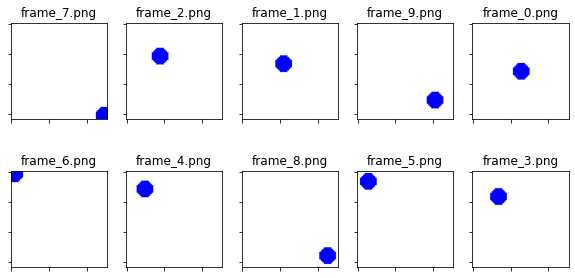

In [35]:
# 设置每行和每列子图的数量
rows = 2
cols = 5

# 创建一个新的图像，并设置子图的布局
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 5))
 
# 确保你的图像数组与子图数量匹配
assert len(imgs_list) == rows * cols
 
# 遍历所有子图，并显示对应的图像
for i, ax in enumerate(axes.flat):
    # 假设images里存储的是图像的数组或者是图像路径
    image = Image.open(os.path.join(path, imgs_list[i]))  # 获取第i个图像
    ax.imshow(image)  # 在子图上显示图像
    ax.set(xticklabels=[], yticklabels=[], title=f'{imgs_list[i]}')  # 移除坐标轴刻度和标题
 
# 在最后一个子图后面添加一个空的轴，避免多余的图像边框
# axes[-1, -1].set(xticks=[], yticks=[])
 
# 展示图像
plt.show()

## 迭代生成的视频数据

In [36]:
# Iterate over the number of videos to generate
for i in range(num_videos):
    # Randomly choose a prompt and movement from the predefined list
    prompt, shape, direction = random.choice(prompts_and_movements)

    # Create a directory for the current video
    video_dir = f'training_dataset/video_{i}'
    os.makedirs(video_dir, exist_ok=True)

    # Write the chosen prompt to a text file in the video directory
    with open(f'{video_dir}/prompt.txt', 'w') as f:
        f.write(prompt)

    # Generate frames for the current video
    for frame_num in range(frames_per_video):
        # Create an image with a moving shape based on the current frame number, shape, and direction
        img = create_image_with_moving_shape(img_size, frame_num, shape, direction)

        # Save the generated image as a PNG file in the video directory
        cv2.imwrite(f'{video_dir}/frame_{frame_num}.png', img)

## 再次可视化数据

In [37]:
path = 'training_dataset/video_0'
os.listdir(path)

['frame_7.png',
 'frame_2.png',
 'frame_1.png',
 'frame_9.png',
 'frame_0.png',
 'frame_6.png',
 'frame_4.png',
 'prompt.txt',
 'frame_8.png',
 'frame_5.png',
 'frame_3.png']

In [38]:
imgs_list = [img_name for img_name in os.listdir(path) if img_name.endswith("png")]
imgs_list

['frame_7.png',
 'frame_2.png',
 'frame_1.png',
 'frame_9.png',
 'frame_0.png',
 'frame_6.png',
 'frame_4.png',
 'frame_8.png',
 'frame_5.png',
 'frame_3.png']

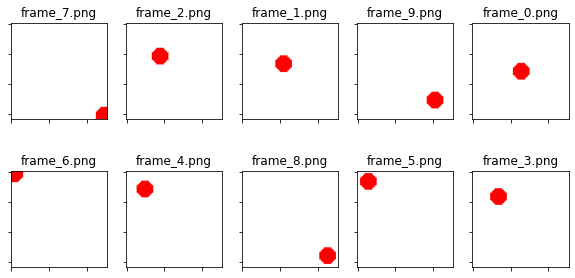

In [40]:
# 设置每行和每列子图的数量
rows = 2
cols = 5

# 创建一个新的图像，并设置子图的布局
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 5))
 
# 确保你的图像数组与子图数量匹配
assert len(imgs_list) == rows * cols
 
# 遍历所有子图，并显示对应的图像
for i, ax in enumerate(axes.flat):
    # 假设images里存储的是图像的数组或者是图像路径
    image = Image.open(os.path.join(path, imgs_list[i]))  # 获取第i个图像
    ax.imshow(image)  # 在子图上显示图像
    ax.set(xticklabels=[], yticklabels=[], title=f'{imgs_list[i]}')  # 移除坐标轴刻度和标题
 
# 在最后一个子图后面添加一个空的轴，避免多余的图像边框
# axes[-1, -1].set(xticks=[], yticks=[])
 
# 展示图像
plt.show()

## Pre-Processing Our Training Data

In [41]:
# Define a dataset class inheriting from torch.utils.data.Dataset
class TextToVideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Initialize the dataset with root directory and optional transform
        self.root_dir = root_dir
        self.transform = transform
        # List all subdirectories in the root directory
        self.video_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        # Initialize lists to store frame paths and corresponding prompts
        self.frame_paths = []
        self.prompts = []

        # Loop through each video directory
        for video_dir in self.video_dirs:
            # List all PNG files in the video directory and store their paths
            frames = [os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith('.png')]
            self.frame_paths.extend(frames)
            # Read the prompt text file in the video directory and store its content
            with open(os.path.join(video_dir, 'prompt.txt'), 'r') as f:
                prompt = f.read().strip()
            # Repeat the prompt for each frame in the video and store in prompts list
            self.prompts.extend([prompt] * len(frames))

    # Return the total number of samples in the dataset
    def __len__(self):
        return len(self.frame_paths)

    # Retrieve a sample from the dataset given an index
    def __getitem__(self, idx):
        # Get the path of the frame corresponding to the given index
        frame_path = self.frame_paths[idx]
        # Open the image using PIL (Python Imaging Library)
        image = Image.open(frame_path)
        # Get the prompt corresponding to the given index
        prompt = self.prompts[idx]

        # Apply transformation if specified
        if self.transform:
            image = self.transform(image)

        # Return the transformed image and the prompt
        return image, prompt

# Define a set of transformations to be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL Image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize image with mean and standard deviation
])

# Load the dataset using the defined transform
dataset = TextToVideoDataset(root_dir='training_dataset', transform=transform)
# Create a dataloader to iterate over the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

## 实现GAN网络

In [42]:
# Define a class for text embedding
class TextEmbedding(nn.Module):
    # Constructor method with vocab_size and embed_size parameters
    def __init__(self, vocab_size, embed_size):
        # Call the superclass constructor
        super(TextEmbedding, self).__init__()
        # Initialize embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)

    # Define the forward pass method
    def forward(self, x):
        # Return embedded representation of input
        return self.embedding(x)

class Generator(nn.Module):
    def __init__(self, text_embed_size):
        super(Generator, self).__init__()

        # Fully connected layer that takes noise and text embedding as input
        self.fc1 = nn.Linear(100 + text_embed_size, 256 * 8 * 8)

        # Transposed convolutional layers to upsample the input
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(64, 3, 4, 2, 1)  # Output has 3 channels for RGB images

        # Activation functions
        self.relu = nn.ReLU(True)  # ReLU activation function
        self.tanh = nn.Tanh()       # Tanh activation function for final output

    def forward(self, noise, text_embed):
        # Concatenate noise and text embedding along the channel dimension
        x = torch.cat((noise, text_embed), dim=1)

        # Fully connected layer followed by reshaping to 4D tensor
        x = self.fc1(x).view(-1, 256, 8, 8)

        # Upsampling through transposed convolution layers with ReLU activation
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))

        # Final layer with Tanh activation to ensure output values are between -1 and 1 (for images)
        x = self.tanh(self.deconv3(x))

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Convolutional layers to process input images
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)   # 3 input channels (RGB), 64 output channels, kernel size 4x4, stride 2, padding 1
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1) # 64 input channels, 128 output channels, kernel size 4x4, stride 2, padding 1
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1) # 128 input channels, 256 output channels, kernel size 4x4, stride 2, padding 1

        # Fully connected layer for classification
        self.fc1 = nn.Linear(256 * 8 * 8, 1)  # Input size 256x8x8 (output size of last convolution), output size 1 (binary classification)

        # Activation functions
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)  # Leaky ReLU activation with negative slope 0.2
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for final output (probability)

    def forward(self, input):
        # Pass input through convolutional layers with LeakyReLU activation
        x = self.leaky_relu(self.conv1(input))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))

        # Flatten the output of convolutional layers
        x = x.view(-1, 256 * 8 * 8)

        # Pass through fully connected layer with Sigmoid activation for binary classification
        x = self.sigmoid(self.fc1(x))

        return x

## 定义训练参数

In [43]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a simple vocabulary for text prompts
all_prompts = [prompt for prompt, _, _ in prompts_and_movements]  # Extract all prompts from prompts_and_movements list
vocab = {word: idx for idx, word in enumerate(set(" ".join(all_prompts).split()))}  # Create a vocabulary dictionary where each unique word is assigned an index
vocab_size = len(vocab)  # Size of the vocabulary
embed_size = 10  # Size of the text embedding vector

def encode_text(prompt):
    # Encode a given prompt into a tensor of indices using the vocabulary
    return torch.tensor([vocab[word] for word in prompt.split()])

# Initialize models, loss function, and optimizers
text_embedding = TextEmbedding(vocab_size, embed_size).to(device)  # Initialize TextEmbedding model with vocab_size and embed_size
netG = Generator(embed_size).to(device)  # Initialize Generator model with embed_size
netD = Discriminator().to(device)  # Initialize Discriminator model
criterion = nn.BCELoss().to(device)  # Binary Cross Entropy loss function
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))  # Adam optimizer for Discriminator
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))  # Adam optimizer for Generator

## 开始训练

In [45]:
# Number of epochs
num_epochs = 13

# Iterate over each epoch
for epoch in range(num_epochs):
    # Iterate over each batch of data
    for i, (data, prompts) in enumerate(dataloader):
        # Move real data to device
        real_data = data.to(device)

        # Convert prompts to list
        prompts = [prompt for prompt in prompts]

        # Update Discriminator
        netD.zero_grad()  # Zero the gradients of the Discriminator
        batch_size = real_data.size(0)  # Get the batch size
        labels = torch.ones(batch_size, 1).to(device)  # Create labels for real data (ones)
        output = netD(real_data)  # Forward pass real data through Discriminator
        lossD_real = criterion(output, labels)  # Calculate loss on real data
        lossD_real.backward()  # Backward pass to calculate gradients

        # Generate fake data
        noise = torch.randn(batch_size, 100).to(device)  # Generate random noise
        text_embeds = torch.stack([text_embedding(encode_text(prompt).to(device)).mean(dim=0) for prompt in prompts])  # Encode prompts into text embeddings
        fake_data = netG(noise, text_embeds)  # Generate fake data from noise and text embeddings
        labels = torch.zeros(batch_size, 1).to(device)  # Create labels for fake data (zeros)
        output = netD(fake_data.detach())  # Forward pass fake data through Discriminator (detach to avoid gradients flowing back to Generator)
        lossD_fake = criterion(output, labels)  # Calculate loss on fake data
        lossD_fake.backward()  # Backward pass to calculate gradients
        optimizerD.step()  # Update Discriminator parameters

        # Update Generator
        netG.zero_grad()  # Zero the gradients of the Generator
        labels = torch.ones(batch_size, 1).to(device)  # Create labels for fake data (ones) to fool Discriminator
        output = netD(fake_data)  # Forward pass fake data (now updated) through Discriminator
        lossG = criterion(output, labels)  # Calculate loss for Generator based on Discriminator's response
        lossG.backward()  # Backward pass to calculate gradients
        optimizerG.step()  # Update Generator parameters

    # Print epoch information
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss D: {lossD_real + lossD_fake}, Loss G: {lossG}")

Epoch [1/13] Loss D: 1.0374624729156494, Loss G: 1.3534207344055176
Epoch [2/13] Loss D: 0.4848950505256653, Loss G: 1.7781351804733276
Epoch [3/13] Loss D: 0.7841371893882751, Loss G: 1.9132435321807861
Epoch [4/13] Loss D: 0.7063266038894653, Loss G: 1.5531724691390991
Epoch [5/13] Loss D: 0.8676729798316956, Loss G: 1.336061716079712
Epoch [6/13] Loss D: 0.6229318380355835, Loss G: 1.8652677536010742
Epoch [7/13] Loss D: 0.58481365442276, Loss G: 1.5654113292694092
Epoch [8/13] Loss D: 0.8892362713813782, Loss G: 1.363067865371704
Epoch [9/13] Loss D: 0.4978178143501282, Loss G: 1.9640638828277588
Epoch [10/13] Loss D: 0.7926355600357056, Loss G: 1.8885732889175415
Epoch [11/13] Loss D: 0.7638837099075317, Loss G: 1.4744945764541626
Epoch [12/13] Loss D: 0.5586493015289307, Loss G: 1.3388292789459229
Epoch [13/13] Loss D: 0.6265643835067749, Loss G: 1.7371184825897217


## 保存模型

In [46]:
# Save the Generator model's state dictionary to a file named 'generator.pth'
torch.save(netG.state_dict(), 'generator.pth')

# Save the Discriminator model's state dictionary to a file named 'discriminator.pth'
torch.save(netD.state_dict(), 'discriminator.pth')

## 推理，生成AI视频

In [47]:
# Inference function to generate a video based on a given text prompt
def generate_video(text_prompt, num_frames=10):
    # Create a directory for the generated video frames based on the text prompt
    os.makedirs(f'generated_video_{text_prompt.replace(" ", "_")}', exist_ok=True)

    # Encode the text prompt into a text embedding tensor
    text_embed = text_embedding(encode_text(text_prompt).to(device)).mean(dim=0).unsqueeze(0)

    # Generate frames for the video
    for frame_num in range(num_frames):
        # Generate random noise
        noise = torch.randn(1, 100).to(device)

        # Generate a fake frame using the Generator network
        with torch.no_grad():
            fake_frame = netG(noise, text_embed)

        # Save the generated fake frame as an image file
        save_image(fake_frame, f'generated_video_{text_prompt.replace(" ", "_")}/frame_{frame_num}.png')

# usage of the generate_video function with a specific text prompt
generate_video('circle moving up-right')

## 可视化生成的视频帧

In [49]:
path = 'generated_video_circle_moving_up-right'
os.listdir(path)

['frame_7.png',
 'frame_2.png',
 'frame_1.png',
 'frame_9.png',
 '.ipynb_checkpoints',
 'frame_0.png',
 'frame_6.png',
 'frame_4.png',
 'frame_8.png',
 'frame_5.png',
 'frame_3.png']

In [50]:
imgs_list = [img_name for img_name in os.listdir(path) if img_name.endswith("png")]
imgs_list

['frame_7.png',
 'frame_2.png',
 'frame_1.png',
 'frame_9.png',
 'frame_0.png',
 'frame_6.png',
 'frame_4.png',
 'frame_8.png',
 'frame_5.png',
 'frame_3.png']

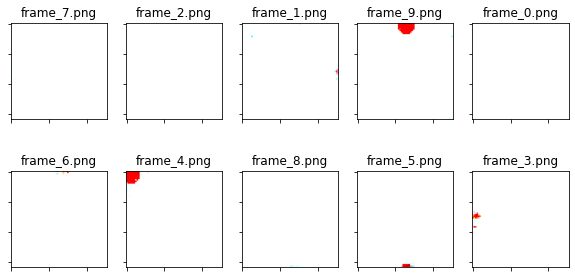

In [51]:
# 设置每行和每列子图的数量
rows = 2
cols = 5

# 创建一个新的图像，并设置子图的布局
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 5))
 
# 确保你的图像数组与子图数量匹配
assert len(imgs_list) == rows * cols
 
# 遍历所有子图，并显示对应的图像
for i, ax in enumerate(axes.flat):
    # 假设images里存储的是图像的数组或者是图像路径
    image = Image.open(os.path.join(path, imgs_list[i]))  # 获取第i个图像
    ax.imshow(image)  # 在子图上显示图像
    ax.set(xticklabels=[], yticklabels=[], title=f'{imgs_list[i]}')  # 移除坐标轴刻度和标题
 
# 在最后一个子图后面添加一个空的轴，避免多余的图像边框
# axes[-1, -1].set(xticks=[], yticks=[])
 
# 展示图像
plt.show()

## 合成视频

In [52]:
# Define the path to your folder containing the PNG frames
folder_path = 'generated_video_circle_moving_up-right'

# Get the list of all PNG files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

# Sort the images by name (assuming they are numbered sequentially)
image_files.sort()

# Create a list to store the frames
frames = []

# Read each image and append it to the frames list
for image_file in image_files:
  image_path = os.path.join(folder_path, image_file)
  frame = cv2.imread(image_path)
  frames.append(frame)

# Convert the frames list to a numpy array for easier processing
frames = np.array(frames)

# Define the frame rate (frames per second)
fps = 10

# Create a video writer object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('generated_video.avi', fourcc, fps, (frames[0].shape[1], frames[0].shape[0]))

# Write each frame to the video
for frame in frames:
  out.write(frame)

# Release the video writer
out.release()

## 可视化生成好的视频

我测试了这个架构的各个方面，发现训练数据是关键。通过在数据集中包含更多的运动和形状，您可以增加可变性并提高模型的性能。由于数据是通过代码生成的，因此生成更多样化的数据不会花费太多时间；相反，你可以专注于完善逻辑。此外，本notebook中讨论的GAN架构相对简单。您可以通过集成高级技术或使用语言模型嵌入（LLM）而不是基本的神经网络嵌入来使其更加复杂。此外，调整嵌入大小等参数会显著影响模型的有效性。

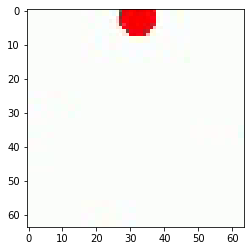

In [69]:
import cv2
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 读取视频
video_path = 'generated_video.avi'  # 这里替换成你的视频文件路径
vid = imageio.get_reader(video_path, 'ffmpeg')

# 设置图形
fig = plt.figure()
ims = []

for frame in vid:
    im = plt.imshow(frame, animated=True)
    ims.append([im])

# 创建动画
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

# 显示动画
HTML(ani.to_jshtml())
